In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#load the saved pickle file for converting apars to obs coords
arm = 'leading'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. 
    
else :
    phi1_min=-38.
    phi1_max=-2.
    

with open('pkl_files/gd1_smooth_pepper_{}_Plummer_td3.4_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

            
dir='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p9CDM/{}/'.format(arm)
#dir1= dir + 'physical_coord/'

print (dir)

allfname= glob.glob(dir + '*.dat')



for jj in allfname:
    
    #print (jj)
    #'#apar   dens_unp   dens  omega_unp   omega'
    dat=np.loadtxt(jj)
    apar=dat[:,0]
    dens_smooth=dat[:,1]
    dens=dat[:,2]
    Omega=dat[:,4]
    
    try:
        mT= sdf_pepper.meanTrack(apar,_mO=Omega,coord='lb')
        outphi1= numpy.arange(phi1_min,phi1_max,2.) 
        #print (outphi1)
        phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
        #print (phi1)
        phi1[phi1 > 180.]-=360.
        #print phi1
        #print (outphi1)
        # Interpolate density
        
        if phi1[1] < phi1[0] :
            
            ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apar[::-1])
            #ipdens= interpolate.InterpolatedUnivariateSpline(apar,dens/dens_smooth)
            
        else :
            ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apar)
            #ipdens= interpolate.InterpolatedUnivariateSpline(apar,dens/dens_smooth)
            

        pp= Polynomial.fit(apar,dens,deg=3)
        #outphi1= numpy.linspace(-60.,-5.,300)
        # Interpolate density
        ipdens= interpolate.InterpolatedUnivariateSpline(apar,dens/pp(apar))

        #plt.figure(figsize=(8,6))
        #plt.plot(outphi1,ipdens(ipphi1(outphi1)))
        #plt.xlabel(r'$\phi_{1}$ (deg)')
        #plt.ylabel(r'norm density')
        #plt.savefig('plots/weird_density.pdf')
        #plt.show()

        #ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)
        fo=open(jj.replace('densOmega','phi1{}_{}_polynorm3'.format(min(outphi1),max(outphi1))),'w')
        fo.write('#phi1   dens/dens_smooth' + '\n')

        for ii in range(len(outphi1)):
            fo.write(str(outphi1[ii]) + '   ' + str(ipdens(ipphi1(outphi1))[ii]) + '\n')

        fo.close()
        
    except ValueError:
        print (jj)


In [2]:
def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def set_ranges_and_labels_dens_noY():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylim(0.001,20.)
    xlim(1.,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None 

In [3]:
gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)
midphi1=gaia_dat['phi1mid']
lin_den = gaia_dat['lindens']
elin_den=gaia_dat['e_lindens']
phi2=gaia_dat['phi2']
ephi2=gaia_dat['e_phi2']

print (min(midphi1),max(midphi1))

# Apply cuts -60. < phi1 < -5.
# leading -60 < phi1 < -42 
# trailing -38 < phi1 < -4

phi1_cut=[]
lin_den_cut=[]
elin_den_cut=[]
phi2_cut=[]
ephi2_cut =[]

for ii in range(len(midphi1)):
    if -60. <= midphi1[ii] <= -4. :
        phi1_cut.append(midphi1[ii])
        lin_den_cut.append(lin_den[ii])
        elin_den_cut.append(elin_den[ii])
        phi2_cut.append(phi2[ii])
        ephi2_cut.append(ephi2[ii])

phi1_cut=np.array(phi1_cut)
lin_den_cut=np.array(lin_den_cut)
elin_den_cut=np.array(elin_den_cut)
phi2_cut=np.array(phi2_cut)
ephi2_cut=np.array(ephi2_cut)


# remove 2 degree on each side of -40 deg where the progenitor could have been
phi1_cut_lead = phi1_cut[phi1_cut < -40.]
lin_den_cut_lead = lin_den_cut[phi1_cut < -40.]
elin_den_cut_lead = elin_den_cut[phi1_cut < -40.]
phi2_cut_lead = phi2_cut[phi1_cut < -40.]
ephi2_cut_lead = ephi2_cut[phi1_cut < -40.]

phi1_cut_trail = phi1_cut[phi1_cut > -40.]
lin_den_cut_trail = lin_den_cut[phi1_cut > -40.]
elin_den_cut_trail = elin_den_cut[phi1_cut > -40.]
phi2_cut_trail = phi2_cut[phi1_cut > -40.]
ephi2_cut_trail = ephi2_cut[phi1_cut > -40.]

#fit 3rd order polynomial
pp_lead= Polynomial.fit(phi1_cut_lead,lin_den_cut_lead,deg=3,w=1/(elin_den_cut_lead))  #for linear density
pp_trail= Polynomial.fit(phi1_cut_trail,lin_den_cut_trail,deg=3,w=1/(elin_den_cut_trail))

pp_phi2_lead= Polynomial.fit(phi1_cut_lead,phi2_cut_lead,deg=3,w=1/(ephi2_cut_lead))   # for track
pp_phi2_trail= Polynomial.fit(phi1_cut_trail,phi2_cut_trail,deg=3,w=1/(ephi2_cut_trail))   # for track

#normalize density, track and errors
norm_den_lead = lin_den_cut_lead/pp_lead(phi1_cut_lead)
norm_den_err_lead = elin_den_cut_lead/pp_lead(phi1_cut_lead)
norm_phi2_cut_lead= phi2_cut_lead - pp_phi2_lead(phi1_cut_lead)

norm_den_trail = lin_den_cut_trail/pp_trail(phi1_cut_trail)
norm_den_err_trail = elin_den_cut_trail/pp_trail(phi1_cut_trail)
norm_phi2_cut_trail= phi2_cut_trail - pp_phi2_trail(phi1_cut_trail)



-90.0 30.0


In [4]:
print (phi1_cut_lead,phi1_cut_trail)

print (numpy.arange(-60.,-42.,2.))

[-60. -58. -56. -54. -52. -50. -48. -46. -44. -42.] [-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
[-60. -58. -56. -54. -52. -50. -48. -46. -44.]


In [13]:
def Pk_data(phi1,norm_den,norm_den_err):
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)


#plots power spectrum from dens already converted to observed coordinates
def pk_scatter(folder,N,p1min=0.,p1max=1000.,scatter=False,zorder=1,ls='-',lw=2.,CDM=True,baryons=False,scaling='spectrum'):
    
    fnames=glob.glob(folder + '*.dat')
    filename0=fnames[0] 
    dat0=np.loadtxt(filename0)
    ll=dat0[:,0][(p1min <= dat0[:,0]) & (dat0[:,0] <= p1max)]
    print (ll)
    tdata=dat0[:,1][(p1min <= dat0[:,0]) & (dat0[:,0] <= p1max)]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
       
    ppy= numpy.empty((N,len(px)))
          
    if baryons :
        print ('adding power due to the bar and spiral arms in quadrature')
        #power due to spiral arms and the bar
        datS= numpy.loadtxt('GD1_density_botharms_streamdf_N4_spiral_5Gyr_24p5patspeed_Rs3kpc_FR1_poly3norm.dat')
        datB= numpy.loadtxt('GD1_density_botharms_1010Msun_spraydf_5Gyr_39patspeed_poly3norm.dat')
        
        p1S=datS[:,0][(p1min < datS[:,0]) & (datS[:,0] < p1max)]
        p1B=datB[:,0][(p1min < datB[:,0]) & (datB[:,0] < p1max)]
        
        print (p1S,p1B)
        tdataS=datS[:,1][(p1min < datS[:,0]) & (datS[:,0] < p1max)]
        tdataB=datB[:,1][(p1min < datB[:,0]) & (datB[:,0] < p1max)]
        pxS,pyS= signal.csd(tdataS,tdataS,fs=1./(p1S[1]-p1S[0]),scaling=scaling,nperseg=len(p1S))
        pxB,pyB= signal.csd(tdataB,tdataB,fs=1./(p1B[1]-p1B[0]),scaling=scaling,nperseg=len(p1B))
        pyS= pyS.real
        pyB= pyB.real
        #pxS= 1./pxS
        #pxB= 1./pxB
        py_SB2= pyS + pyB # these are already squared
                    
    if not baryons:
        py_SB2=np.zeros(len(px))
        
      
    ppy[0]=py + py_SB2
    
    for ii in range(1,N):
        filename=fnames[ii]
        dat=np.loadtxt(filename)
        ll=dat[:,0][(p1min <= dat[:,0]) & (dat[:,0] <= p1max)]
        tdata=dat[:,1][(p1min <= dat[:,0]) & (dat[:,0] <= p1max)]
        ppy1= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
        #print (ppy1,py_SB2)
        if not CDM :
            ppy1 = np.zeros(len(px))
            
        
        ppy[ii]=ppy1 + py_SB2
    
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                
    
def plot_pk_scatter(folder,N,p1min=0.,p1max=1000.,color='k',zorder=1,ls='-',
              fill=True,fill_color='k',fill_zorder=0,label='',CDM=True,baryons=False):
    
    
    px, py= pk_scatter(folder=folder,p1min=p1min,p1max=p1max,N=N,CDM=CDM,baryons=baryons)
    print (px)
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        plotx, dum, low, high= pk_scatter(folder,N=N,p1min=p1min,p1max=p1max,scatter=True,CDM=CDM,baryons=baryons)
    
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    legend(loc='upper left',fontsize=12)    
    return None  

px,py_noise_med,ppy_noise_low,ppy_noise_high,py_err_dat = Pk_data(phi1_cut_trail,norm_den_trail,norm_den_err_trail)
px_lead,py_noise_med_lead,ppy_noise_low_lead,ppy_noise_high_lead,py_err_dat_lead = Pk_data(phi1_cut_lead,
                                                                                           norm_den_lead,
                                                                                           norm_den_err_lead)

/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.



[-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide

[        inf 36.         18.         12.          9.          7.2
  6.          5.14285714  4.5         4.        ]
[-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
/home/nil/anaconda3/envs/galpy1.4/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide

[-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
[        inf 36.         18.         12.          9.          7.2
  6.          5.14285714  4.5         4.        ]
[-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
[-38. -36. -34. -32. -30. -28. -26. -24. -22. -20. -18. -16. -14. -12.
 -10.  -8.  -6.  -4.]
[        

Text(0,0.5,'$\\sqrt{P_{\\delta\\delta}(k_{\\phi_{1}})}$')

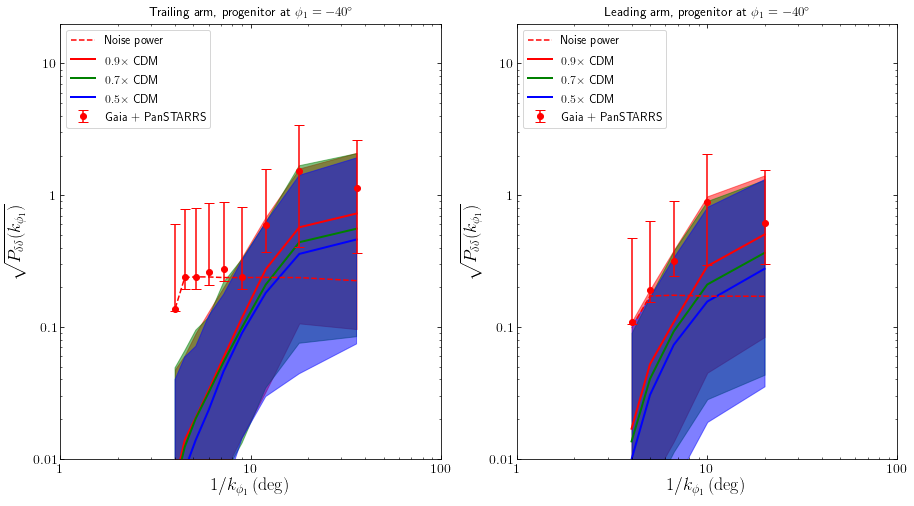

In [14]:
#Plot
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(15,8)
subplot(1,2,1)
title(r'Trailing arm, progenitor at $\phi_{1} = -40^{\circ}$')

arm='trailing'
phi1_min=-38.
phi1_max=-4.

#dir='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/1CDM/{}/physical_coords/'.format(arm)
dir1='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p9CDM/{}/physical_coords/'.format(arm)
dir2='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p7CDM/{}/physical_coords/'.format(arm)
dir3='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p5CDM/{}/physical_coords/'.format(arm)



loglog(px,py_err_dat,color='red',zorder=10,ls='--',label='Noise power')

errorbar(px,py_noise_med,
         yerr=[ppy_noise_low,ppy_noise_high]
         ,color='r',fmt='o',capsize=5.,capthick=1.,ecolor='r',label='Gaia + PanSTARRS')

#plot_pk_scatter(dir,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$1\times$ CDM',CDM=True,baryons=False,color='k',fill_color='k')
plot_pk_scatter(dir1,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.9\times$ CDM',CDM=True,baryons=False,color='r',fill_color='r')
plot_pk_scatter(dir2,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.7\times$ CDM',CDM=True,baryons=False,color='g',fill_color='g')
plot_pk_scatter(dir3,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.5\times$ CDM',CDM=True,baryons=False,color='b',fill_color='b')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)

subplot(1,2,2)
title(r'Leading arm, progenitor at $\phi_{1} = -40^{\circ}$')

arm='leading'
phi1_min=-60.
phi1_max=-42.

#dir='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/1CDM/{}/physical_coords/'.format(arm)
dir1='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p9CDM/{}/physical_coords/'.format(arm)
dir2='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p7CDM/{}/physical_coords/'.format(arm)
dir3='dens_Omega/subhalo_GMC_GC/prog-40/Tstream_3.4/0p5CDM/{}/physical_coords/'.format(arm)



loglog(px_lead,py_err_dat_lead,color='red',zorder=10,ls='--',label='Noise power')

errorbar(px_lead,py_noise_med_lead,
         yerr=[ppy_noise_low_lead,ppy_noise_high_lead]
         ,color='r',fmt='o',capsize=5.,capthick=1.,ecolor='r',label='Gaia + PanSTARRS')

#plot_pk_scatter(dir,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$1\times$ CDM',CDM=True,baryons=False,color='k',fill_color='k')
plot_pk_scatter(dir1,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.9\times$ CDM',CDM=True,baryons=False,color='r',fill_color='r')
plot_pk_scatter(dir2,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.7\times$ CDM',CDM=True,baryons=False,color='g',fill_color='g')
plot_pk_scatter(dir3,N=499,p1min=phi1_min,p1max=phi1_max,label=r'$0.5\times$ CDM',CDM=True,baryons=False,color='b',fill_color='b')
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
#savefig('plots/power_baryons_trailing_arm_prog-40.pdf')
#savefig('plots/power_baryonsonly_trailing_arm_prog-40.pdf')